In [302]:
import pandas as pd
import numpy as np
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Seq import Seq
import difflib
import re
import os

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [245]:
def get_TCR_sequence(left_flank, right_flank, left_flank_rc, right_flank_rc, bl):
    rev_com = False
    res_l = re.search(left_flank, bl)
    res_r = re.search(right_flank, bl)
    res_l_rc = re.search(left_flank_rc, bl)
    res_r_rc = re.search(left_flank_rc, bl)
    if res_l==None or res_r==None:
        res_r = res_l_rc
        res_l = res_r_rc
        rev_com = True
        if res_l==None or res_r==None:
            #print('Not TCR', res_l, res_r)
            return ''
    if res_l.end() > res_r.start():
        return ''
    # See whether the TCR sequence resembles the reference A2KRAS02 sequence; otherwise may be extraneous
    #b = bl[res_l.end():res_r.start()]
    #s = difflib.SequenceMatcher(a=ref, b=b).get_matching_blocks()
    #if len(s) < 2:
    #    print('Dissimilar')
    #    return ''
    if not rev_com:
        return bl[res_l.end():res_r.start()]
    else:
        return Seq(bl[res_l.end():res_r.start()]).reverse_complement()

In [246]:
# Get all files
assembled_fastqs = [x for x in os.listdir('merged') if '.assembled.' in x]
assembled_fastqs.sort()

In [250]:
left_flank = 'TGCGCCGAGATC' #'TCCGCCATCTACTTTTGCGCCGAGATC'
left_flank_rc = 'GATCTCGGCGCA'
right_flank = 'GACAAGCTGATCTTC' #'GACAAGCTGATCTTCGGCACCGGCACCAGAC'
right_flank_rc = 'GAAGATCAGCTTGTC'
ref = 'GAGGACAACACC' # the variable region sequence (not used here)
fastq_lengths = np.zeros(len(assembled_fastqs))
variants = pd.DataFrame(np.zeros(shape=[1, len(assembled_fastqs) + 1]))
variants.iloc[0, 0] = ref # original sequence

for i, file in enumerate(assembled_fastqs):
    temp_file = open('alignment/' + file.split('.')[0] + '.txt', 'w')
    for title, seq, qual in FastqGeneralIterator(open('merged/' + file)):
        # First column of variants df is the TCR sequence
        variant = get_TCR_sequence(left_flank, right_flank, left_flank_rc, right_flank_rc, seq)
        if len(variant)!=len(ref):
            continue
        fastq_lengths[i] += 1
        if variant not in variants.iloc[:, 0].tolist():
            temp = pd.DataFrame(np.zeros(shape=[1, len(assembled_fastqs) + 1]))
            temp.iloc[0, 0] = variant
            temp.iloc[0, 1+i] = 1
            variants = variants.append(temp)
            temp_file.write(variant + '\n')
            #print('New variant')
        elif variant in variants.iloc[:, 0].tolist():
            variants.loc[variants[0]==variant, 1+i] += 1
    temp_file.close()

In [251]:
variants

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,GAGGACAACACC,17.0,1.0,16.0,26.0,4.0,1.0,26.0,115.0,3.0,21.0,18.0,25.0,0.0,26.0,33.0,64.0
0,GAGGACAGTACT,72502.0,71.0,163.0,95.0,4204.0,73.0,224.0,380.0,38.0,208.0,70.0,86844.0,81.0,237.0,84.0,5089.0
0,GCGGATCGGCTG,1820.0,5.0,32.0,6.0,8562.0,6.0,9.0,4794.0,0.0,5.0,5.0,813.0,8.0,1.0,17.0,391.0
0,GAGGACACTAGT,8459.0,6.0,571.0,8.0,1420.0,4.0,1766.0,31.0,8.0,114.0,6.0,5320.0,7.0,183.0,9.0,459.0
0,CCTGCGGGTGCG,43100.0,24.0,23.0,18.0,3755.0,22.0,21.0,14.0,37.0,21.0,17.0,25161.0,31.0,17.0,26.0,1782.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,CAGCAGAGTCGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,ACTTCTCCGGAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,GCGGGGACGGAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0,GGGGGTACGTAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [252]:
variants[variants.iloc[:, 0]=='GAGGACAACACC']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,GAGGACAACACC,17.0,1.0,16.0,26.0,4.0,1.0,26.0,115.0,3.0,21.0,18.0,25.0,0.0,26.0,33.0,64.0


In [264]:
colnames = ['sequence'] + assembled_fastqs
variants.columns = colnames
variants.index = variants['sequence']

In [269]:
variants['sequence'] = variants['sequence'].apply(lambda x: Seq(x))

In [270]:
variants['aa'] = variants['sequence'].apply(lambda x: x.translate())

In [271]:
variants.head()

,sequence,10_S10_R1_R2_merged.fastq.assembled.fastq,11_S11_R1_R2_merged.fastq.assembled.fastq,12_S12_R1_R2_merged.fastq.assembled.fastq,13_S13_R1_R2_merged.fastq.assembled.fastq,14_S14_R1_R2_merged.fastq.assembled.fastq,15_S15_R1_R2_merged.fastq.assembled.fastq,1_S1_R1_R2_merged.fastq.assembled.fastq,2_S2_R1_R2_merged.fastq.assembled.fastq,3_S3_R1_R2_merged.fastq.assembled.fastq,4_S4_R1_R2_merged.fastq.assembled.fastq,5_S5_R1_R2_merged.fastq.assembled.fastq,6_S6_R1_R2_merged.fastq.assembled.fastq,7_S7_R1_R2_merged.fastq.assembled.fastq,8_S8_R1_R2_merged.fastq.assembled.fastq,9_S9_R1_R2_merged.fastq.assembled.fastq,Undetermined_S0_R1_R2_merged.fastq.assembled.fastq,aa
sequence,,,,,,,,,,,,,,,,,,
"(G, A, G, G, A, C, A, A, C, A, C, C)","(G, A, G, G, A, C, A, A, C, A, C, C)",17.0,1.0,16.0,26.0,4.0,1.0,26.0,115.0,3.0,21.0,18.0,25.0,0.0,26.0,33.0,64.0,"(E, D, N, T)"
"(G, A, G, G, A, C, A, G, T, A, C, T)","(G, A, G, G, A, C, A, G, T, A, C, T)",72502.0,71.0,163.0,95.0,4204.0,73.0,224.0,380.0,38.0,208.0,70.0,86844.0,81.0,237.0,84.0,5089.0,"(E, D, S, T)"
"(G, C, G, G, A, T, C, G, G, C, T, G)","(G, C, G, G, A, T, C, G, G, C, T, G)",1820.0,5.0,32.0,6.0,8562.0,6.0,9.0,4794.0,0.0,5.0,5.0,813.0,8.0,1.0,17.0,391.0,"(A, D, R, L)"
"(G, A, G, G, A, C, A, C, T, A, G, T)","(G, A, G, G, A, C, A, C, T, A, G, T)",8459.0,6.0,571.0,8.0,1420.0,4.0,1766.0,31.0,8.0,114.0,6.0,5320.0,7.0,183.0,9.0,459.0,"(E, D, T, S)"
"(C, C, T, G, C, G, G, G, T, G, C, G)","(C, C, T, G, C, G, G, G, T, G, C, G)",43100.0,24.0,23.0,18.0,3755.0,22.0,21.0,14.0,37.0,21.0,17.0,25161.0,31.0,17.0,26.0,1782.0,"(P, A, G, A)"


In [272]:
variants.to_excel('alignment/all_variants.xlsx', index=False)

In [277]:
variants.iloc[:, 1:-1] = variants.iloc[:, 1:-1].divide(fastq_lengths, axis='columns')

In [278]:
variants.to_excel('alignment/all_variants_nl.xlsx', index=False)

In [280]:
aa_variants = variants.groupby('aa').sum()

In [282]:
aa_variants.to_excel('alignment/aa_variants_nl.xlsx', index=True)

In [307]:
def get_sorted_aas(i, threshold):
    s = aa_variants.iloc[:, i].sort_values(ascending=False)
    return s[s > threshold]

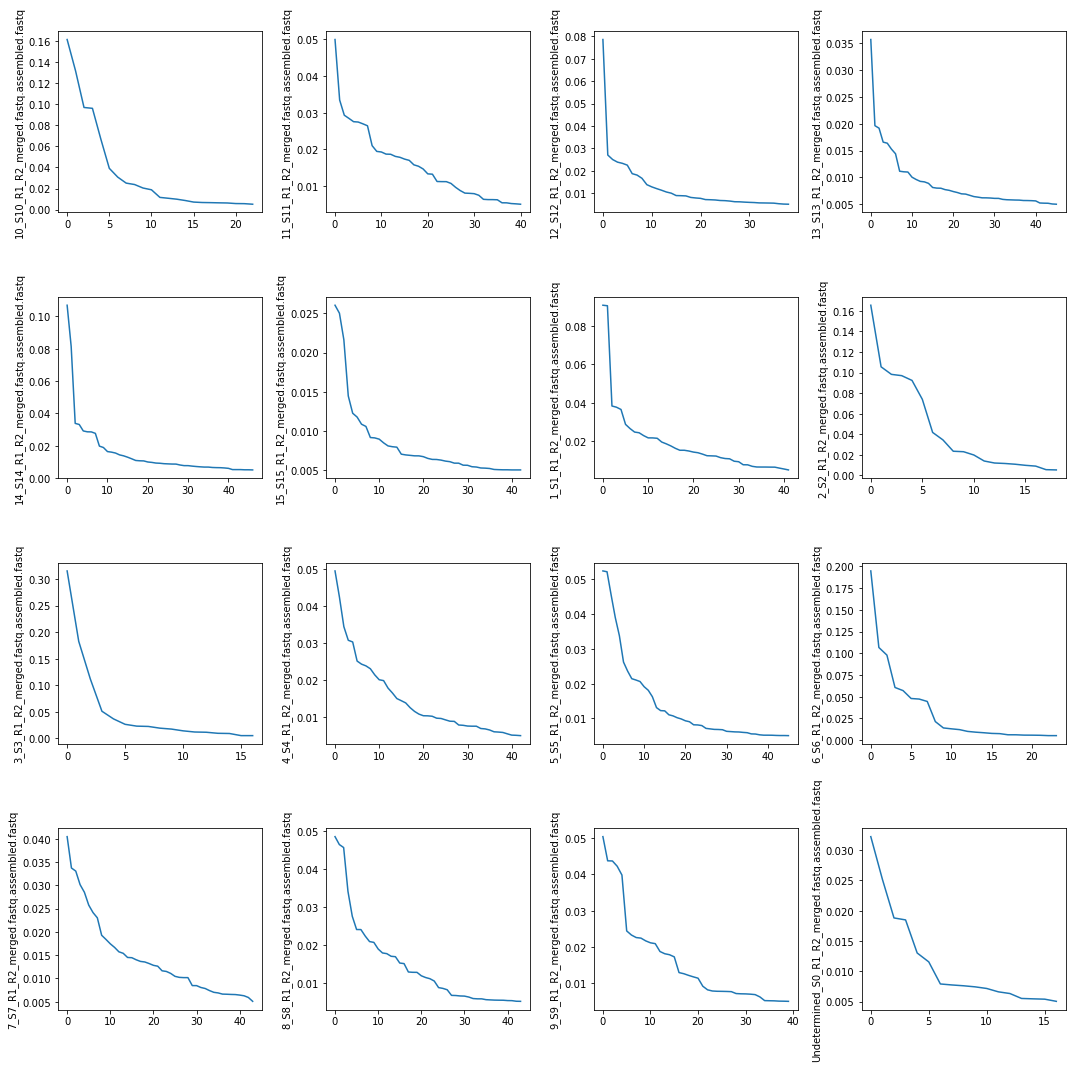

In [323]:
# Plot the frequencies of amino acid sequences per sample
f, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=False)
k = 0
for i in range(4):
    for j in range(4):
        aas = get_sorted_aas(k, 0.005)
        f = sns.lineplot(x=np.arange(0, len(aas)), y=aas, ax=axes[i, j])
        k += 1
plt.tight_layout()